https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128565
## Requirements and Imports

In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from numba import jit
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from pygsp import graphs, filters, plotting
from Annotatability import models, metrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
sc.set_figure_params(scanpy=True, fontsize=16)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
# Read raw data and process it
adata = sc.read('GSE128565_adata_processed.h5ad.h5')
adata

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb'
    obsm: 'X_umap'

In [4]:
sc.pp.filter_genes_dispersion(adata,n_top_genes=3000)
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [5]:
adata_stz = adata[adata.obs['groups_named_broad_cond'].isin(['beta_STZ','beta_GLP1','beta_Ins','beta_InsGLP1','beta_Est','beta_GLP1E',
                                                             'alpha_STZ','alpha_GLP1','alpha_Ins','alpha_InsGLP','alpha_Est','alpha_GLP1E',
                                                             'delta_STZ','delta_GLP1','delta_Ins','delta_InsGLP','delta_Est','delta_GLP1E',])]
adata_stz.obs['cond']='stz'
adata_ctrl = adata[adata.obs['groups_named_broad_cond'].isin(['beta_Ctrl','alpha_Ctrl'
                                                                  ,'delta_Ctrl'])]
adata_ctrl.obs['cond']='ctrl'
adata_stz_ctrl = adata_stz.concatenate(adata_ctrl)
# GLP1/Ins/InsGLP//Est/Glp1E

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38838/475259889.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_stz.obs['cond']='stz'
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38838/475259889.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl.obs['cond']='ctrl'
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata_alpha = adata[adata.obs['groups_named_broad_cond'].isin(['alpha_Ctrl',
                                                             'alpha_STZ','alpha_GLP1','alpha_Ins','alpha_InsGLP','alpha_Est','alpha_GLP1E'])]

adata_beta = adata[adata.obs['groups_named_broad_cond'].isin(['beta_STZ','beta_GLP1','beta_Ins','beta_InsGLP1','beta_Est','beta_GLP1E','beta_Ctrl'])]

adata_delta = adata[adata.obs['groups_named_broad_cond'].isin([ 'delta_STZ','delta_GLP1','delta_Ins','delta_InsGLP','delta_Est','delta_GLP1E','delta_Ctrl'])]


adata_alpha.obs['celltype']='alpha'
adata_beta.obs['celltype']='beta'
adata_delta.obs['celltype']='delta'
adata_celltype = adata_alpha.concatenate(adata_beta)
adata_celltype = adata_celltype.concatenate(adata_delta)


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38838/1398509266.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_alpha.obs['celltype']='alpha'
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38838/1398509266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_beta.obs['celltype']='beta'
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38838/1398509266.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_delta.obs['celltype']='delta'


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


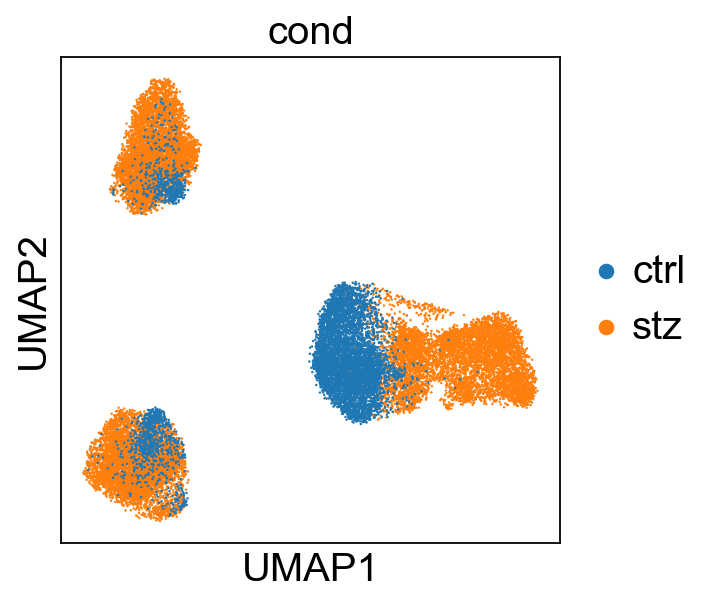

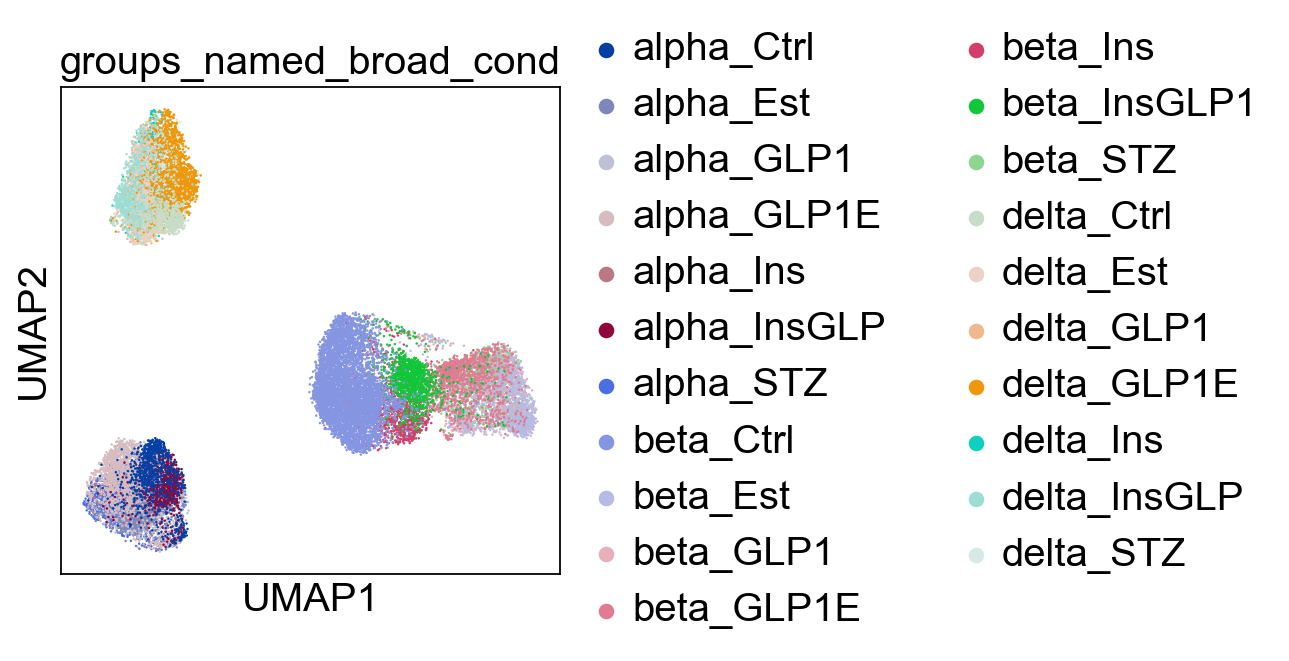

In [7]:
sc.pp.pca(adata_stz_ctrl)
sc.pp.neighbors(adata_stz_ctrl)
sc.tl.umap(adata_stz_ctrl)
sc.pl.umap(adata_stz_ctrl,color=['cond'])
sc.pl.umap(adata_stz_ctrl,color=['groups_named_broad_cond' ])


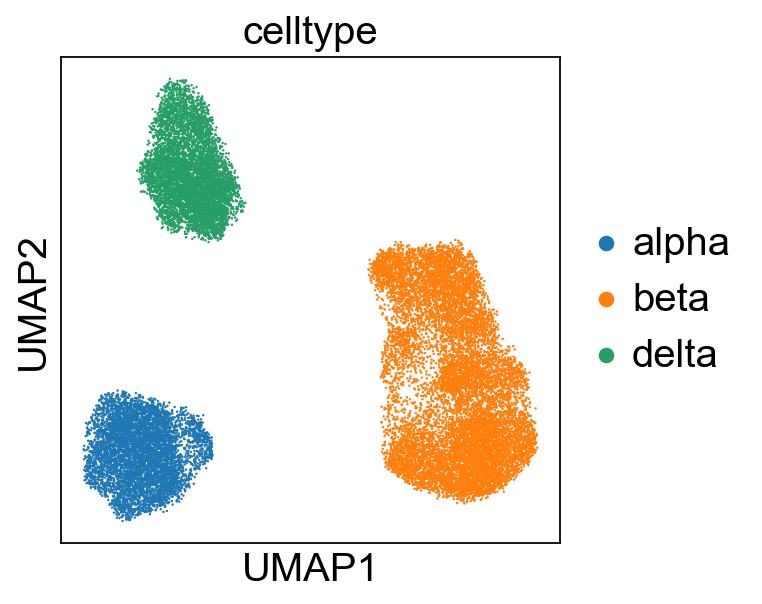

In [8]:
sc.pp.pca(adata_celltype)
sc.pp.neighbors(adata_celltype)
sc.tl.umap(adata_celltype)
sc.pl.umap(adata_celltype,color=['celltype' ])


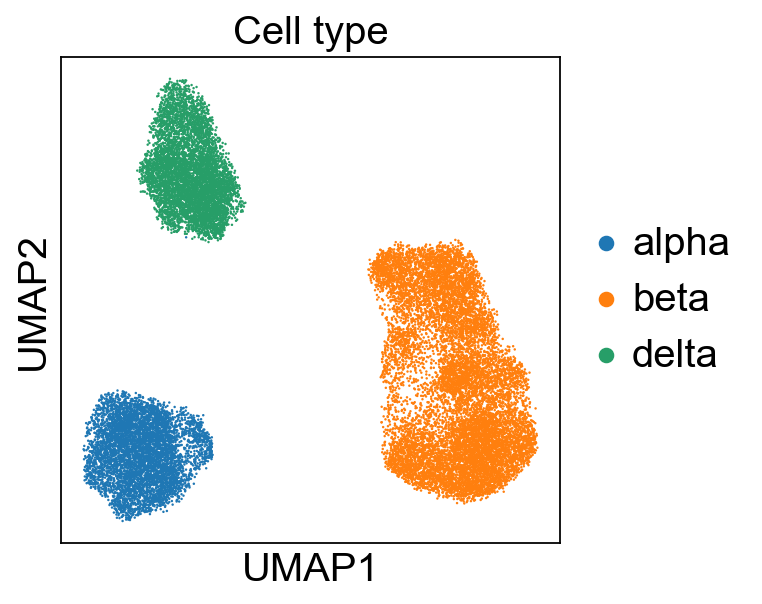

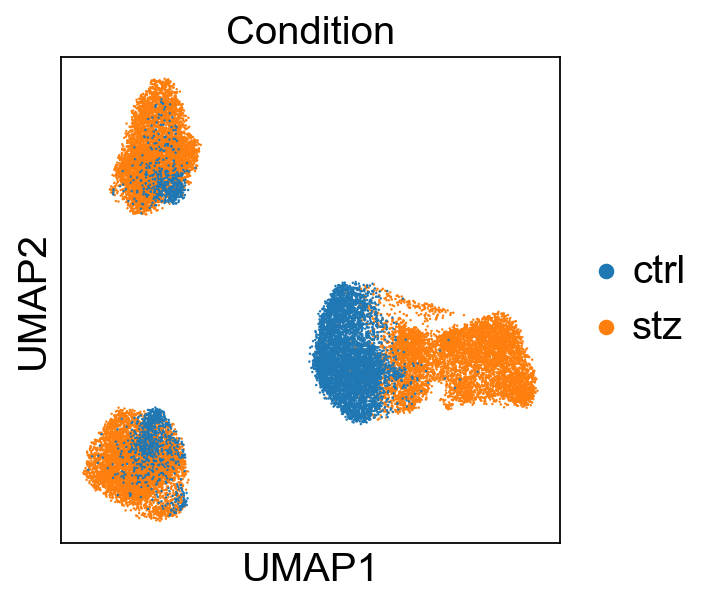

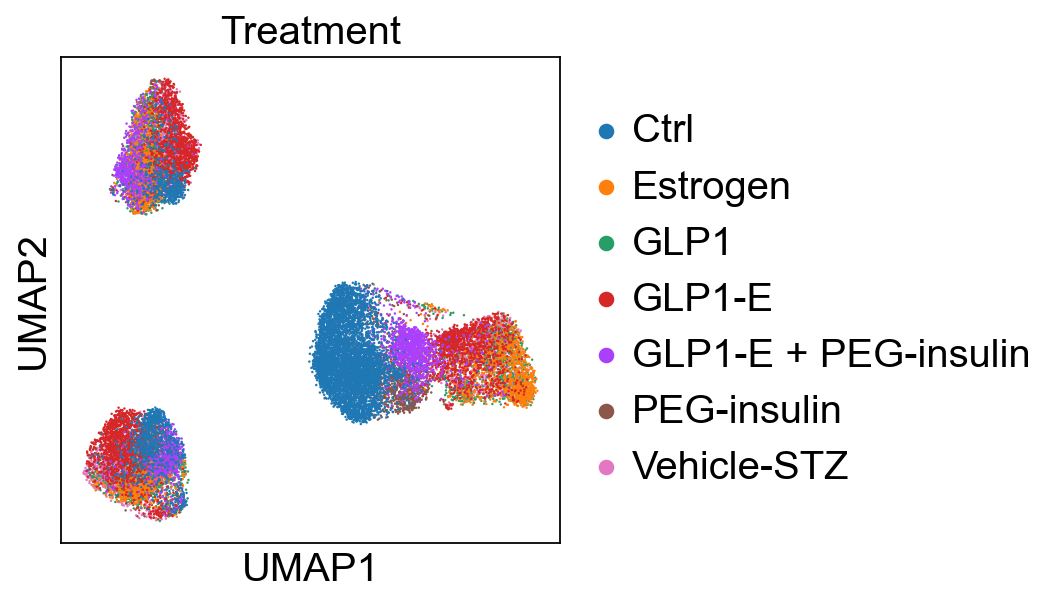

In [9]:
sc.pl.umap(adata_celltype,color=['celltype' ], title='Cell type')
sc.pl.umap(adata_stz_ctrl,color=['cond' ], title='Condition')
sc.pl.umap(adata_stz_ctrl,color=['treatment' ], title='Treatment')


In [10]:
epoch_num=30
prob_list = models.follow_training_dyn_neural_net(adata_stz_ctrl, label_key='cond',iterNum=epoch_num, device=device)

[1,     2] loss: 0.138
[1,    12] loss: 0.673
[1,    22] loss: 0.624
[1,    32] loss: 0.565
[1,    42] loss: 0.508
[1,    52] loss: 0.450
[1,    62] loss: 0.409
[1,    72] loss: 0.381
[1,    82] loss: 0.352
[1,    92] loss: 0.317
[2,     2] loss: 0.063
[2,    12] loss: 0.293
[2,    22] loss: 0.287
[2,    32] loss: 0.280
[2,    42] loss: 0.256
[2,    52] loss: 0.248
[2,    62] loss: 0.231
[2,    72] loss: 0.231
[2,    82] loss: 0.217
[2,    92] loss: 0.203
[3,     2] loss: 0.042
[3,    12] loss: 0.206
[3,    22] loss: 0.197
[3,    32] loss: 0.182
[3,    42] loss: 0.185
[3,    52] loss: 0.177
[3,    62] loss: 0.173
[3,    72] loss: 0.182
[3,    82] loss: 0.158
[3,    92] loss: 0.156
[4,     2] loss: 0.032
[4,    12] loss: 0.168
[4,    22] loss: 0.161
[4,    32] loss: 0.150
[4,    42] loss: 0.147
[4,    52] loss: 0.155
[4,    62] loss: 0.145
[4,    72] loss: 0.145
[4,    82] loss: 0.150
[4,    92] loss: 0.133
[5,     2] loss: 0.032
[5,    12] loss: 0.129
[5,    22] loss: 0.135
[5,    32] 

In [11]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata_stz_ctrl.n_obs, epoch_num=epoch_num)

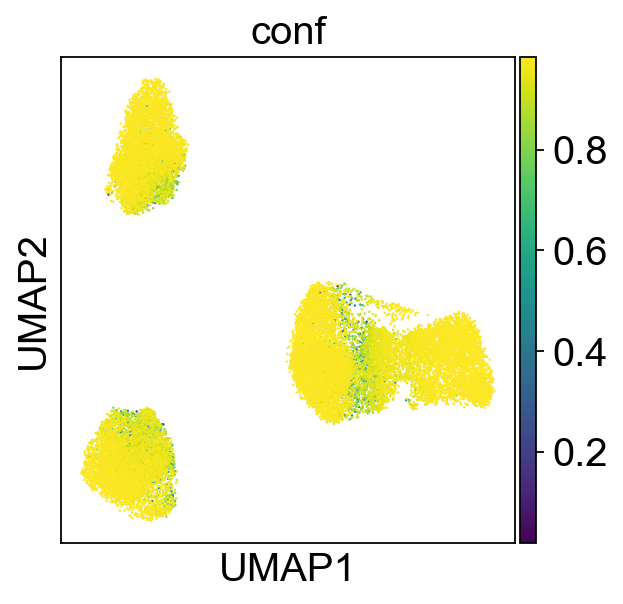

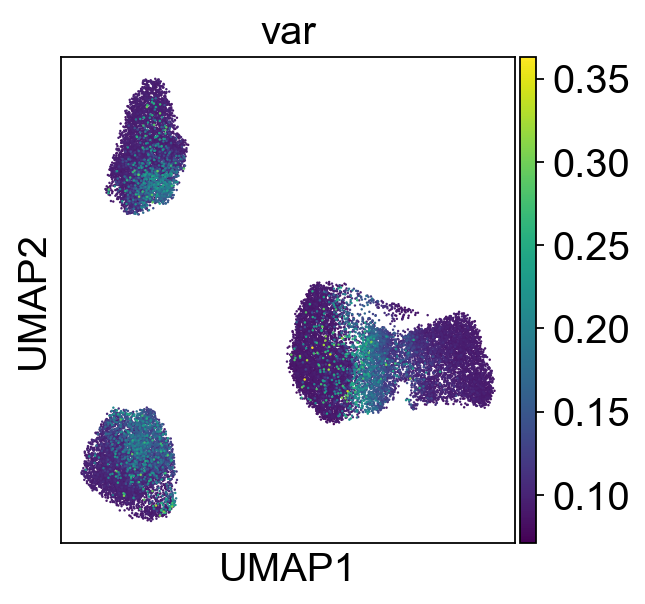

In [12]:
adata_stz_ctrl.obs['conf'] = all_conf.detach().numpy()
adata_stz_ctrl.obs['var'] = all_var.detach().numpy()
sc.pl.umap(adata_stz_ctrl , color='conf')
sc.pl.umap(adata_stz_ctrl , color='var')


In [13]:
epoch_num=30
prob_list = models.follow_training_dyn_neural_net(adata_celltype, label_key='celltype',iterNum=epoch_num, device=device)




[1,     2] loss: 0.218
[1,    12] loss: 1.052
[1,    22] loss: 0.933
[1,    32] loss: 0.762
[1,    42] loss: 0.561
[1,    52] loss: 0.365
[1,    62] loss: 0.217
[1,    72] loss: 0.128
[1,    82] loss: 0.080
[1,    92] loss: 0.056
[2,     2] loss: 0.008
[2,    12] loss: 0.039
[2,    22] loss: 0.031
[2,    32] loss: 0.027
[2,    42] loss: 0.024
[2,    52] loss: 0.020
[2,    62] loss: 0.019
[2,    72] loss: 0.017
[2,    82] loss: 0.015
[2,    92] loss: 0.014
[3,     2] loss: 0.003
[3,    12] loss: 0.012
[3,    22] loss: 0.012
[3,    32] loss: 0.011
[3,    42] loss: 0.012
[3,    52] loss: 0.010
[3,    62] loss: 0.009
[3,    72] loss: 0.008
[3,    82] loss: 0.008
[3,    92] loss: 0.008
[4,     2] loss: 0.002
[4,    12] loss: 0.008
[4,    22] loss: 0.007
[4,    32] loss: 0.007
[4,    42] loss: 0.007
[4,    52] loss: 0.006
[4,    62] loss: 0.006
[4,    72] loss: 0.006
[4,    82] loss: 0.005
[4,    92] loss: 0.006
[5,     2] loss: 0.001
[5,    12] loss: 0.005
[5,    22] loss: 0.005
[5,    32] 

In [14]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata_stz_ctrl.n_obs, epoch_num=epoch_num)

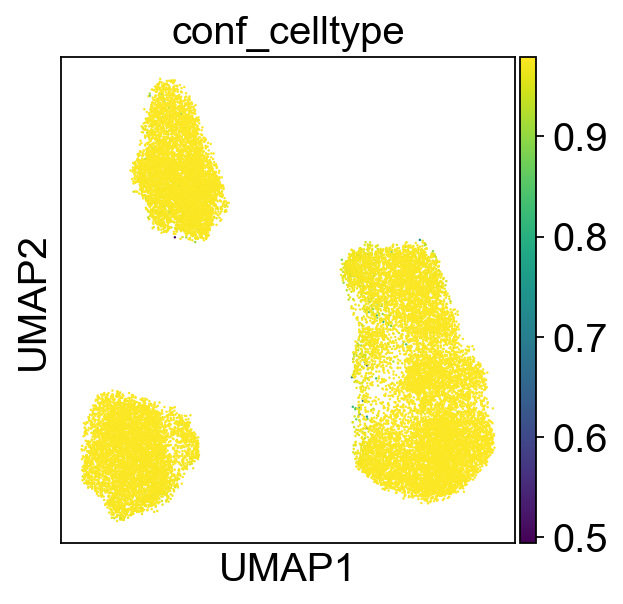

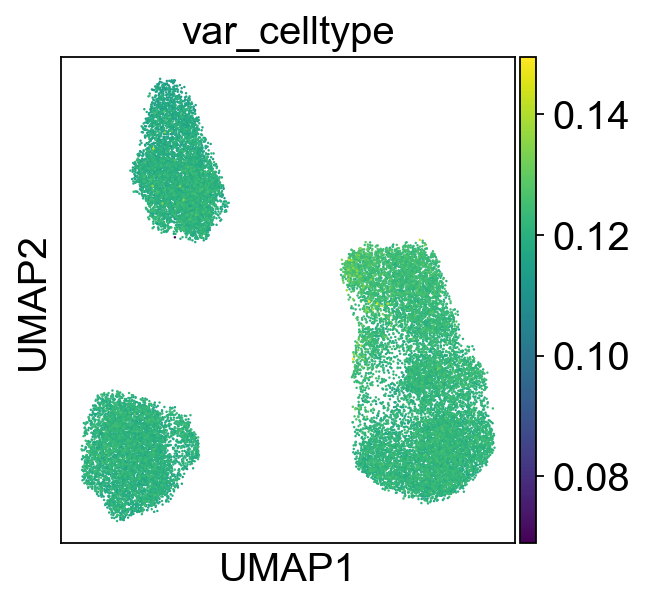

In [15]:
adata_celltype.obs['conf_celltype'] = all_conf.detach().numpy()
adata_celltype.obs['var_celltype'] = all_var.detach().numpy()
sc.pl.umap(adata_celltype , color='conf_celltype')
sc.pl.umap(adata_celltype , color='var_celltype')


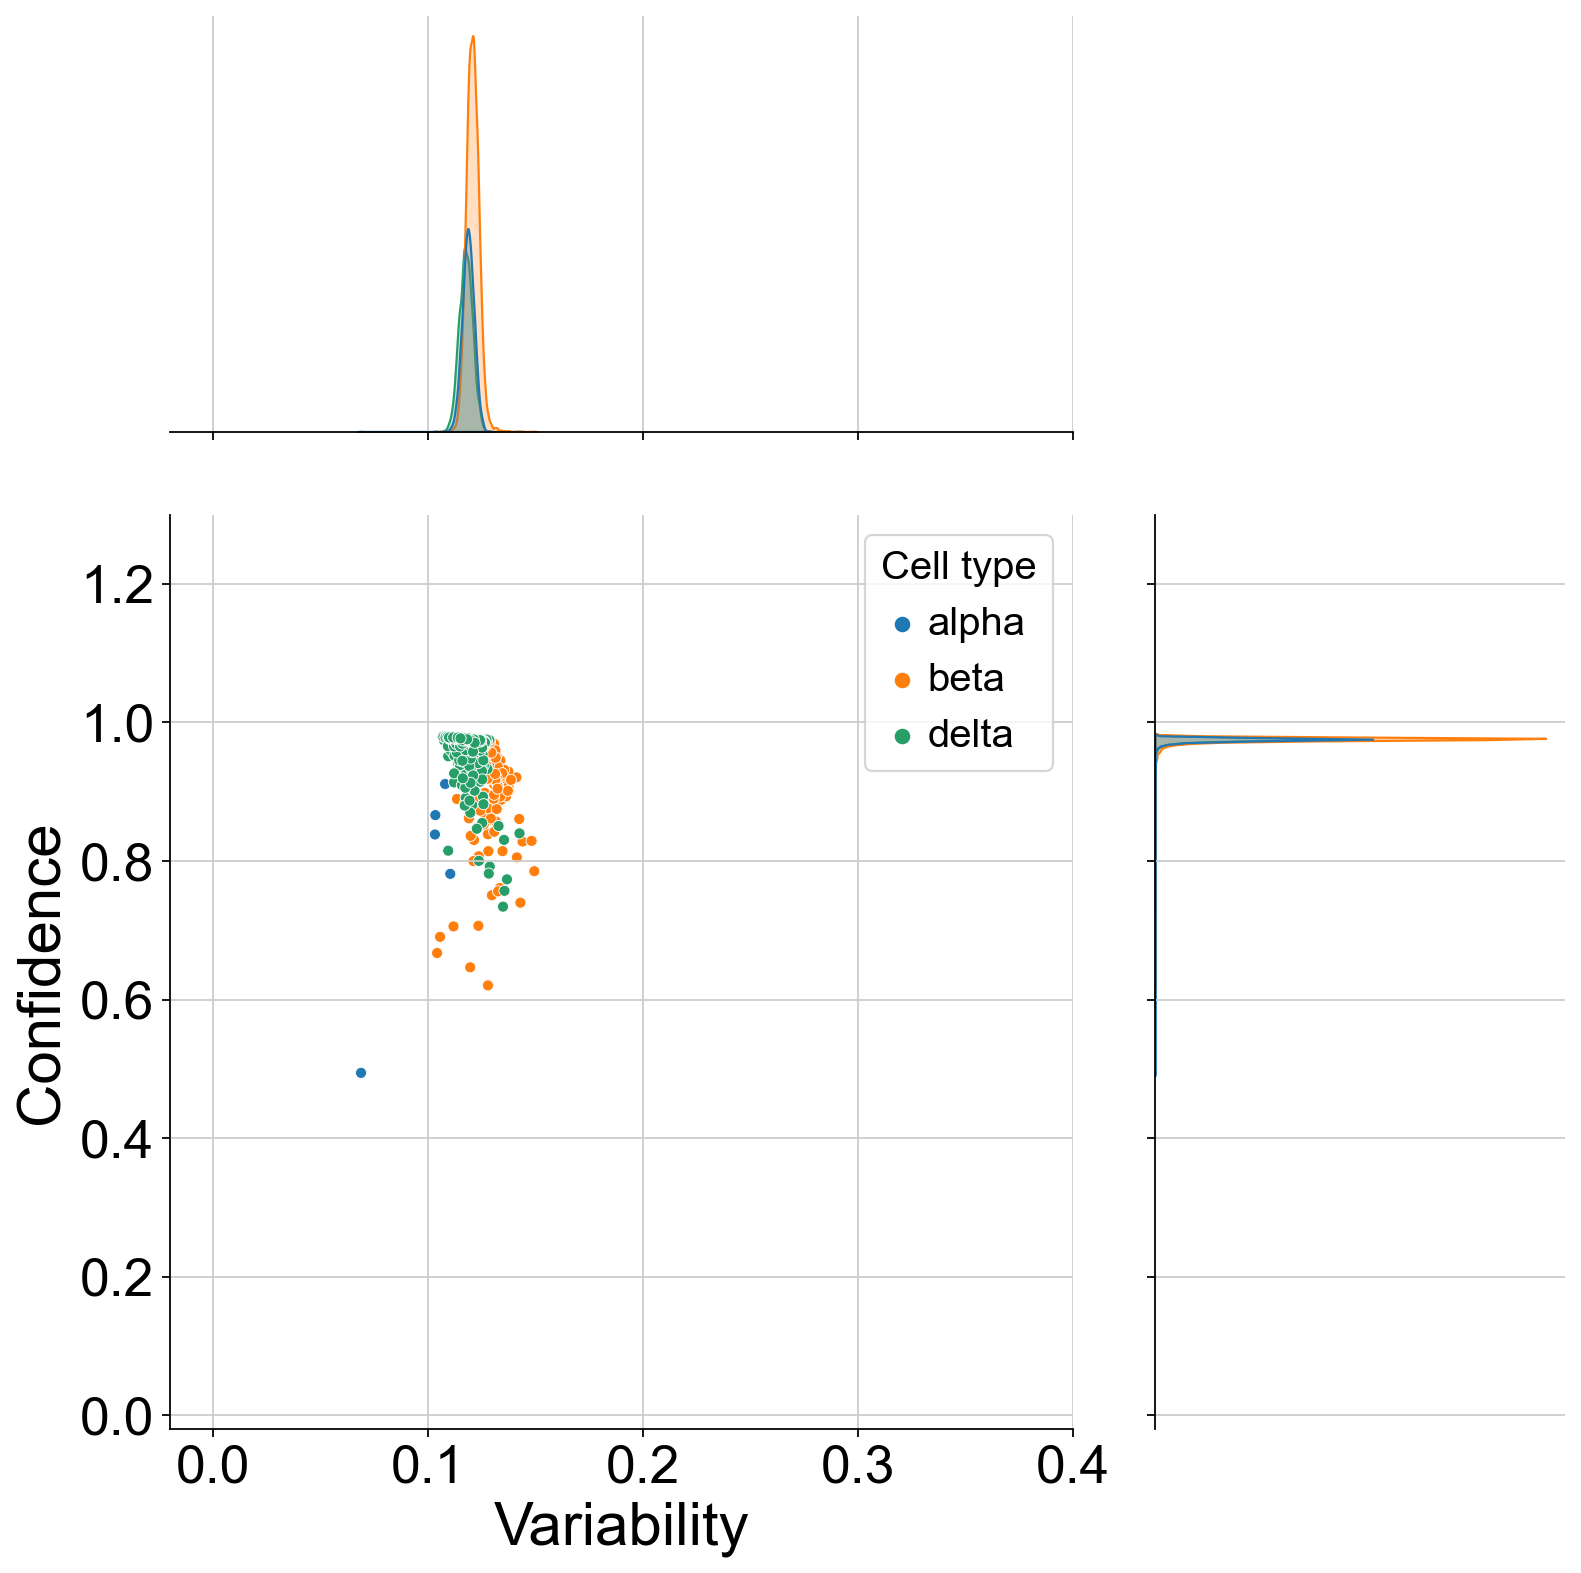

In [16]:
adata_celltype.obs['Confidence']= adata_celltype.obs['conf_celltype']
adata_celltype.obs['Variability']= adata_celltype.obs['var_celltype']
adata_celltype.obs['Cell type']= adata_celltype.obs['celltype']

fig = sns.jointplot(data=adata_celltype.obs, x="Variability", y="Confidence",hue='Cell type',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

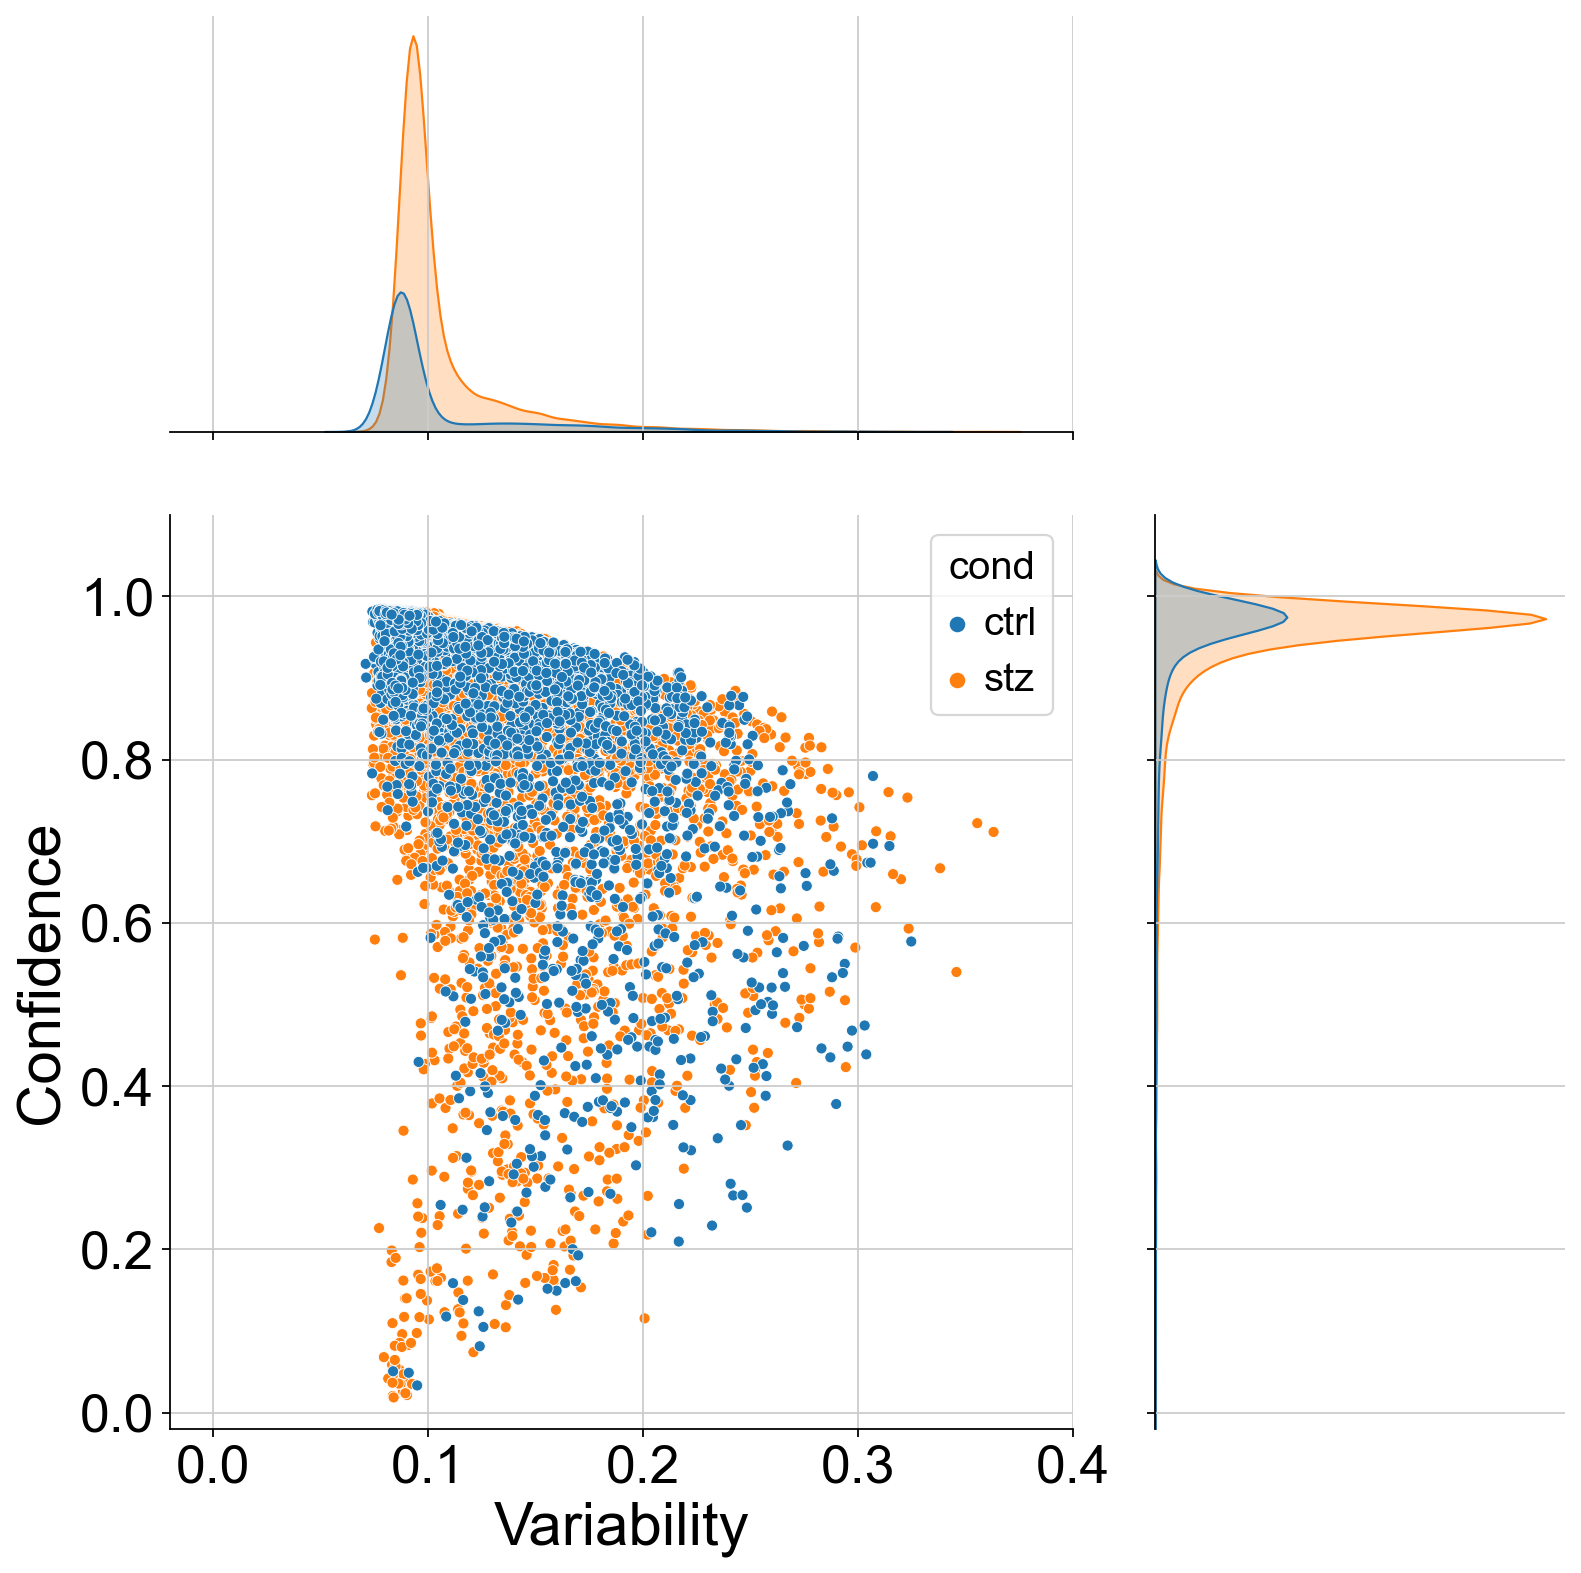

In [17]:
adata_stz_ctrl.obs['Confidence']= adata_stz_ctrl.obs['conf']
adata_stz_ctrl.obs['Variability']= adata_stz_ctrl.obs['var']

fig = sns.jointplot(data=adata_stz_ctrl.obs, x="Variability", y="Confidence",hue='cond',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.1])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

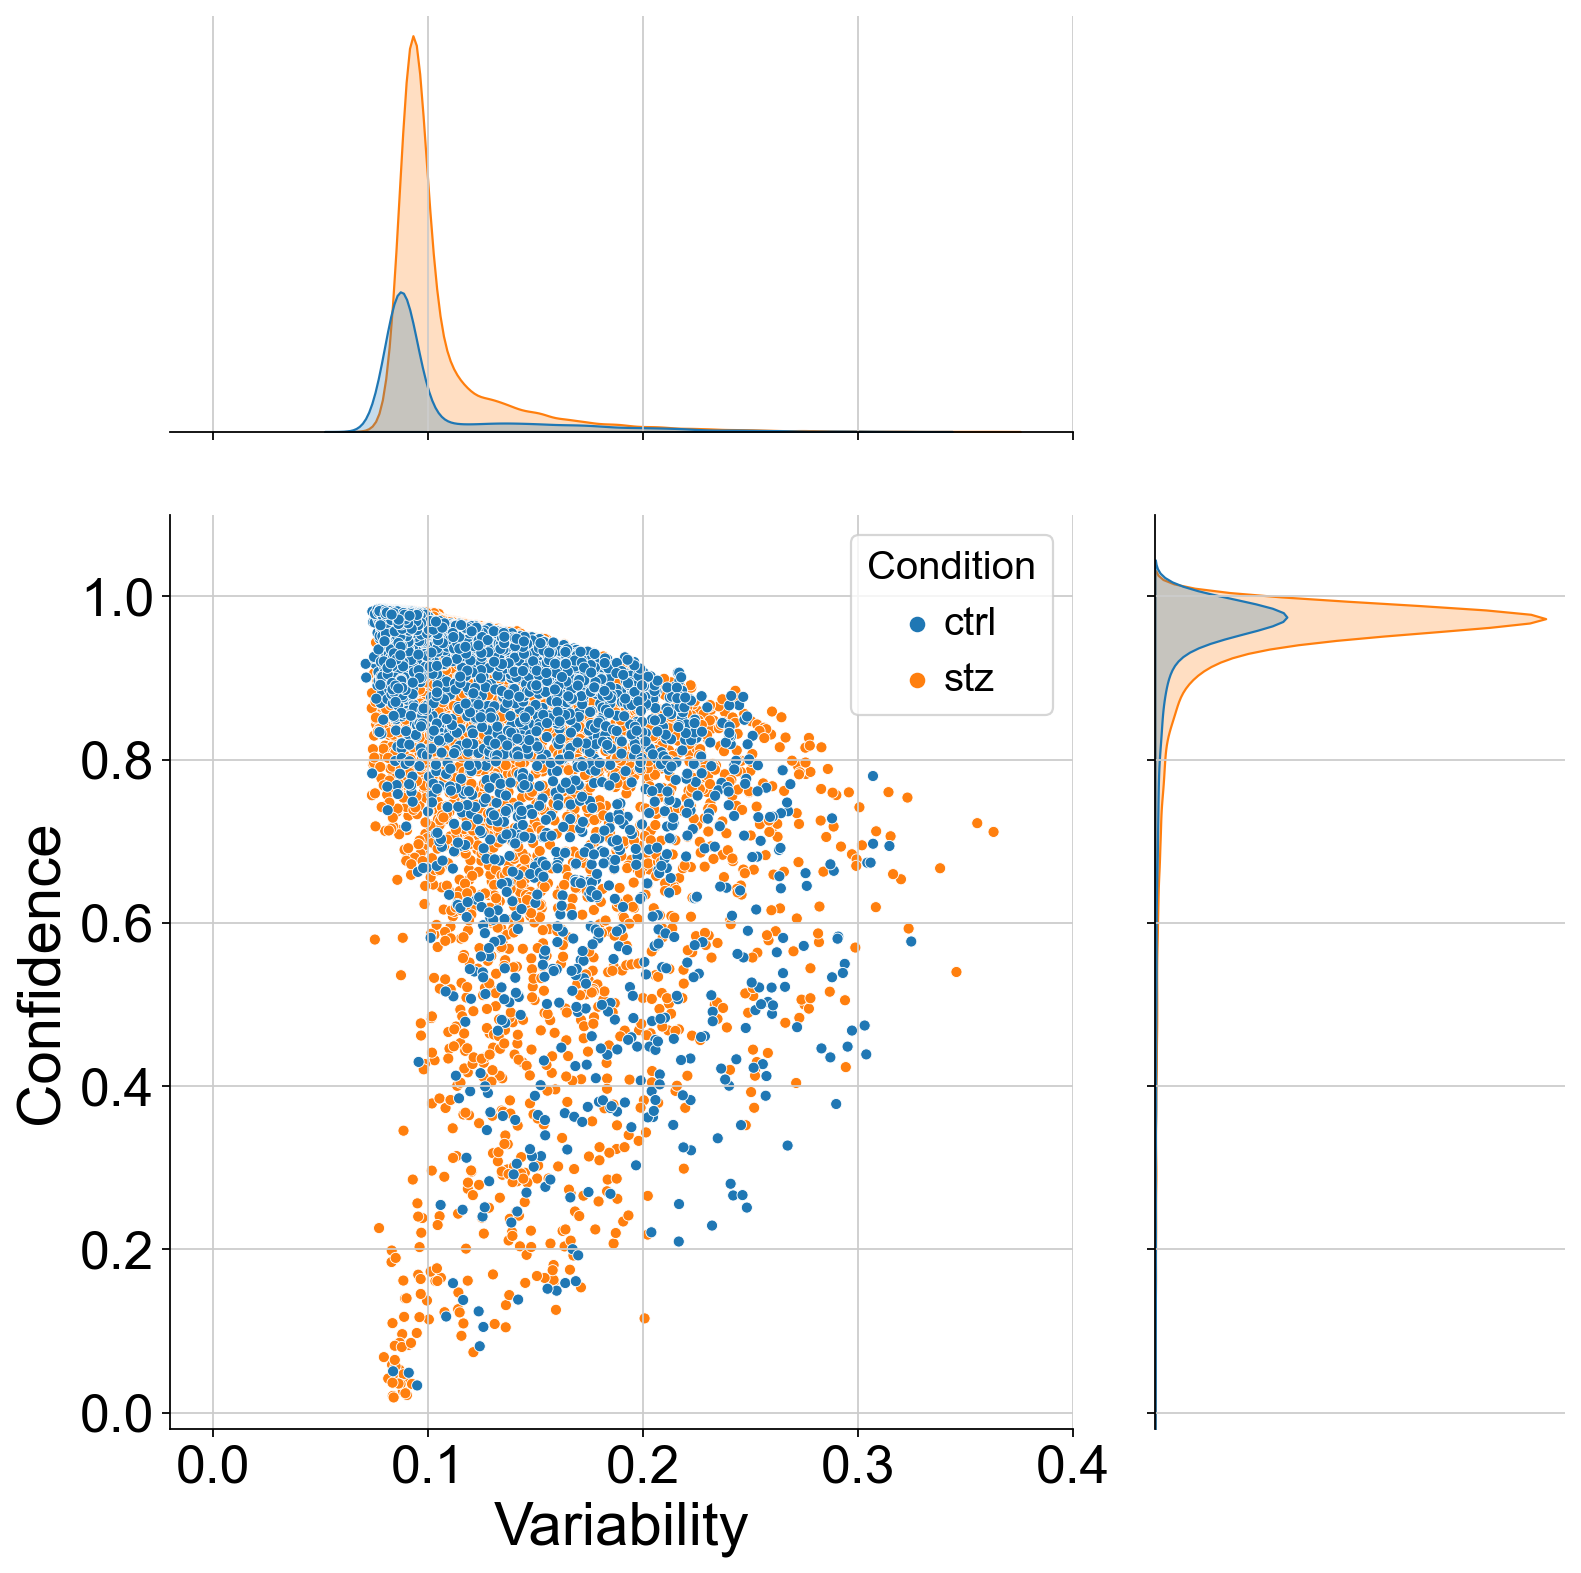

In [18]:
adata_stz_ctrl.obs['Condition']= adata_stz_ctrl.obs['cond']

fig = sns.jointplot(data=adata_stz_ctrl.obs, x="Variability", y="Confidence",hue='Condition',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.1])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

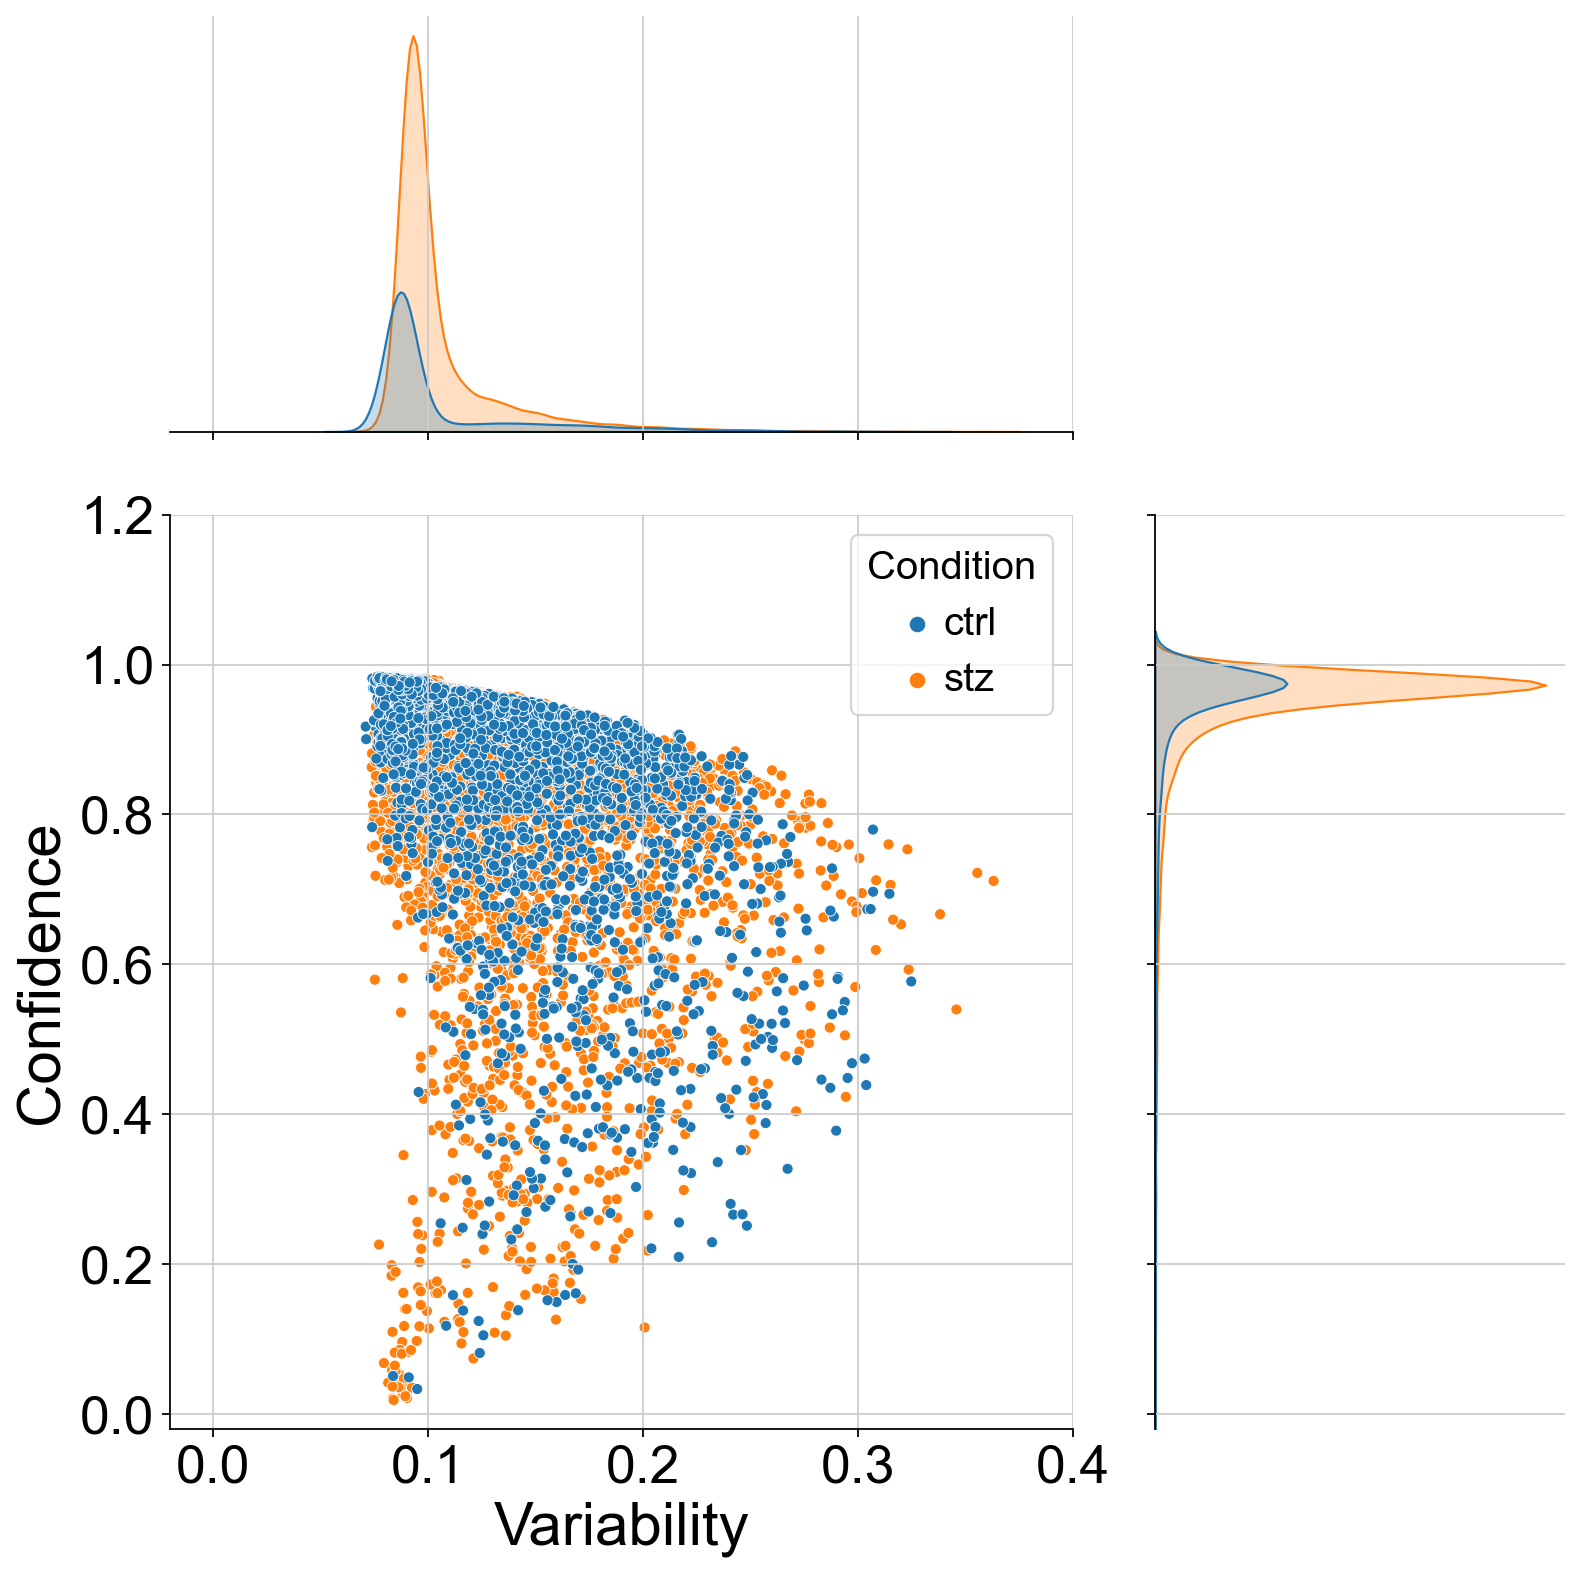

In [19]:
adata_stz_ctrl.obs['Condition']= adata_stz_ctrl.obs['cond']

fig = sns.jointplot(data=adata_stz_ctrl.obs, x="Variability", y="Confidence",hue='Condition',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.2])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

In [20]:
epoch_num=30
prob_list = models.follow_training_dyn_neural_net(adata_stz_ctrl, label_key='treatment',iterNum=epoch_num, device=device)

[1,     2] loss: 0.389
[1,    12] loss: 1.944
[1,    22] loss: 1.927
[1,    32] loss: 1.908
[1,    42] loss: 1.890
[1,    52] loss: 1.868
[1,    62] loss: 1.844
[1,    72] loss: 1.818
[1,    82] loss: 1.794
[1,    92] loss: 1.760
[2,     2] loss: 0.346
[2,    12] loss: 1.706
[2,    22] loss: 1.673
[2,    32] loss: 1.635
[2,    42] loss: 1.623
[2,    52] loss: 1.594
[2,    62] loss: 1.559
[2,    72] loss: 1.529
[2,    82] loss: 1.499
[2,    92] loss: 1.465
[3,     2] loss: 0.289
[3,    12] loss: 1.419
[3,    22] loss: 1.399
[3,    32] loss: 1.351
[3,    42] loss: 1.308
[3,    52] loss: 1.280
[3,    62] loss: 1.279
[3,    72] loss: 1.225
[3,    82] loss: 1.190
[3,    92] loss: 1.166
[4,     2] loss: 0.232
[4,    12] loss: 1.108
[4,    22] loss: 1.117
[4,    32] loss: 1.082
[4,    42] loss: 1.047
[4,    52] loss: 1.030
[4,    62] loss: 0.978
[4,    72] loss: 0.973
[4,    82] loss: 0.955
[4,    92] loss: 0.918
[5,     2] loss: 0.181
[5,    12] loss: 0.889
[5,    22] loss: 0.883
[5,    32] 

In [21]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata_stz_ctrl.n_obs, epoch_num=epoch_num)

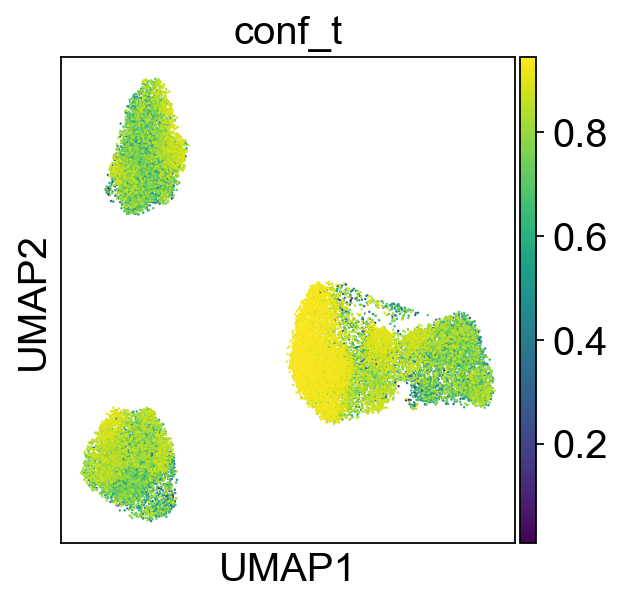

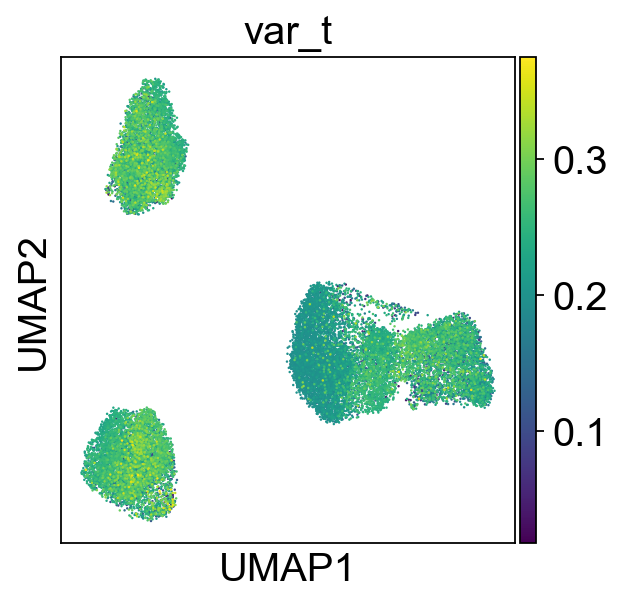

In [22]:
adata_stz_ctrl.obs['conf_t'] = all_conf.detach().numpy()
adata_stz_ctrl.obs['var_t'] = all_var.detach().numpy()
sc.pl.umap(adata_stz_ctrl , color='conf_t')
sc.pl.umap(adata_stz_ctrl , color='var_t')


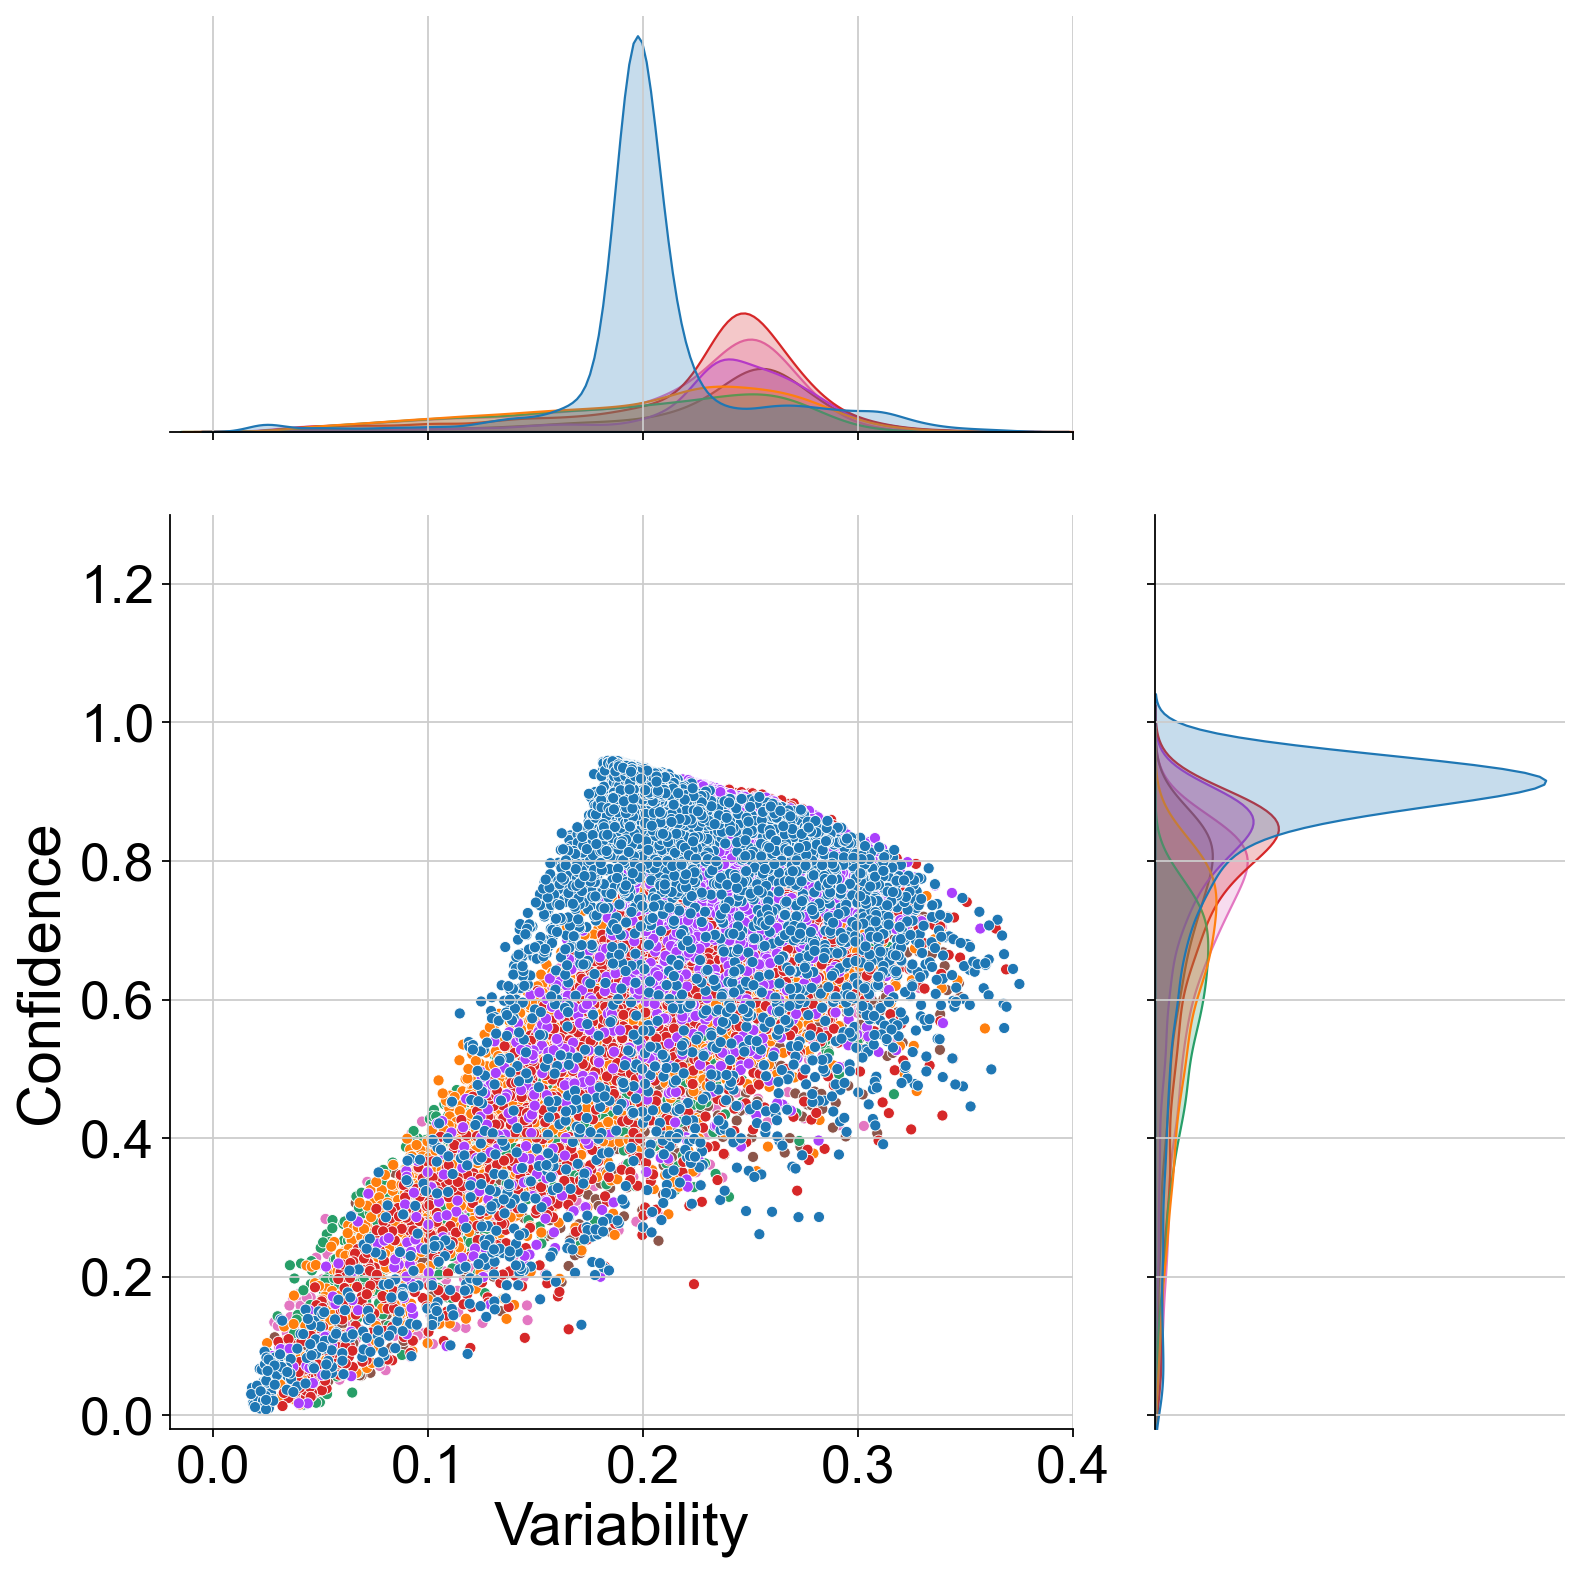

In [23]:
adata_stz_ctrl.obs['Confidence']= adata_stz_ctrl.obs['conf_t']
adata_stz_ctrl.obs['Variability']= adata_stz_ctrl.obs['var_t']

fig = sns.jointplot(data=adata_stz_ctrl.obs, x="Variability", y="Confidence",hue='treatment',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])
fig.ax_joint.legend_.remove()
#fig.fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize

plt.show()


In [24]:
print(np.var(adata_stz_ctrl.obs['conf_t']))
print(np.var(adata_stz_ctrl.obs['var_t']))
print(np.mean(adata_stz_ctrl.obs['conf_t']))
print(np.mean(adata_stz_ctrl.obs['var_t']))


0.04277572
0.0031385857
0.7008316
0.21508066


In [25]:
print(np.var(adata_stz_ctrl.obs['conf']))
print(np.var(adata_stz_ctrl.obs['var']))
print(np.mean(adata_stz_ctrl.obs['conf']))
print(np.mean(adata_stz_ctrl.obs['var']))


0.012792959
0.0010083324
0.9297557
0.10611415


In [26]:
print(np.var(adata_celltype.obs['conf_celltype']))
print(np.var(adata_celltype.obs['var_celltype']))
print(np.mean(adata_celltype.obs['conf_celltype']))
print(np.mean(adata_celltype.obs['var_celltype']))


0.00011057781
1.08742515e-05
0.9744331
0.119459026


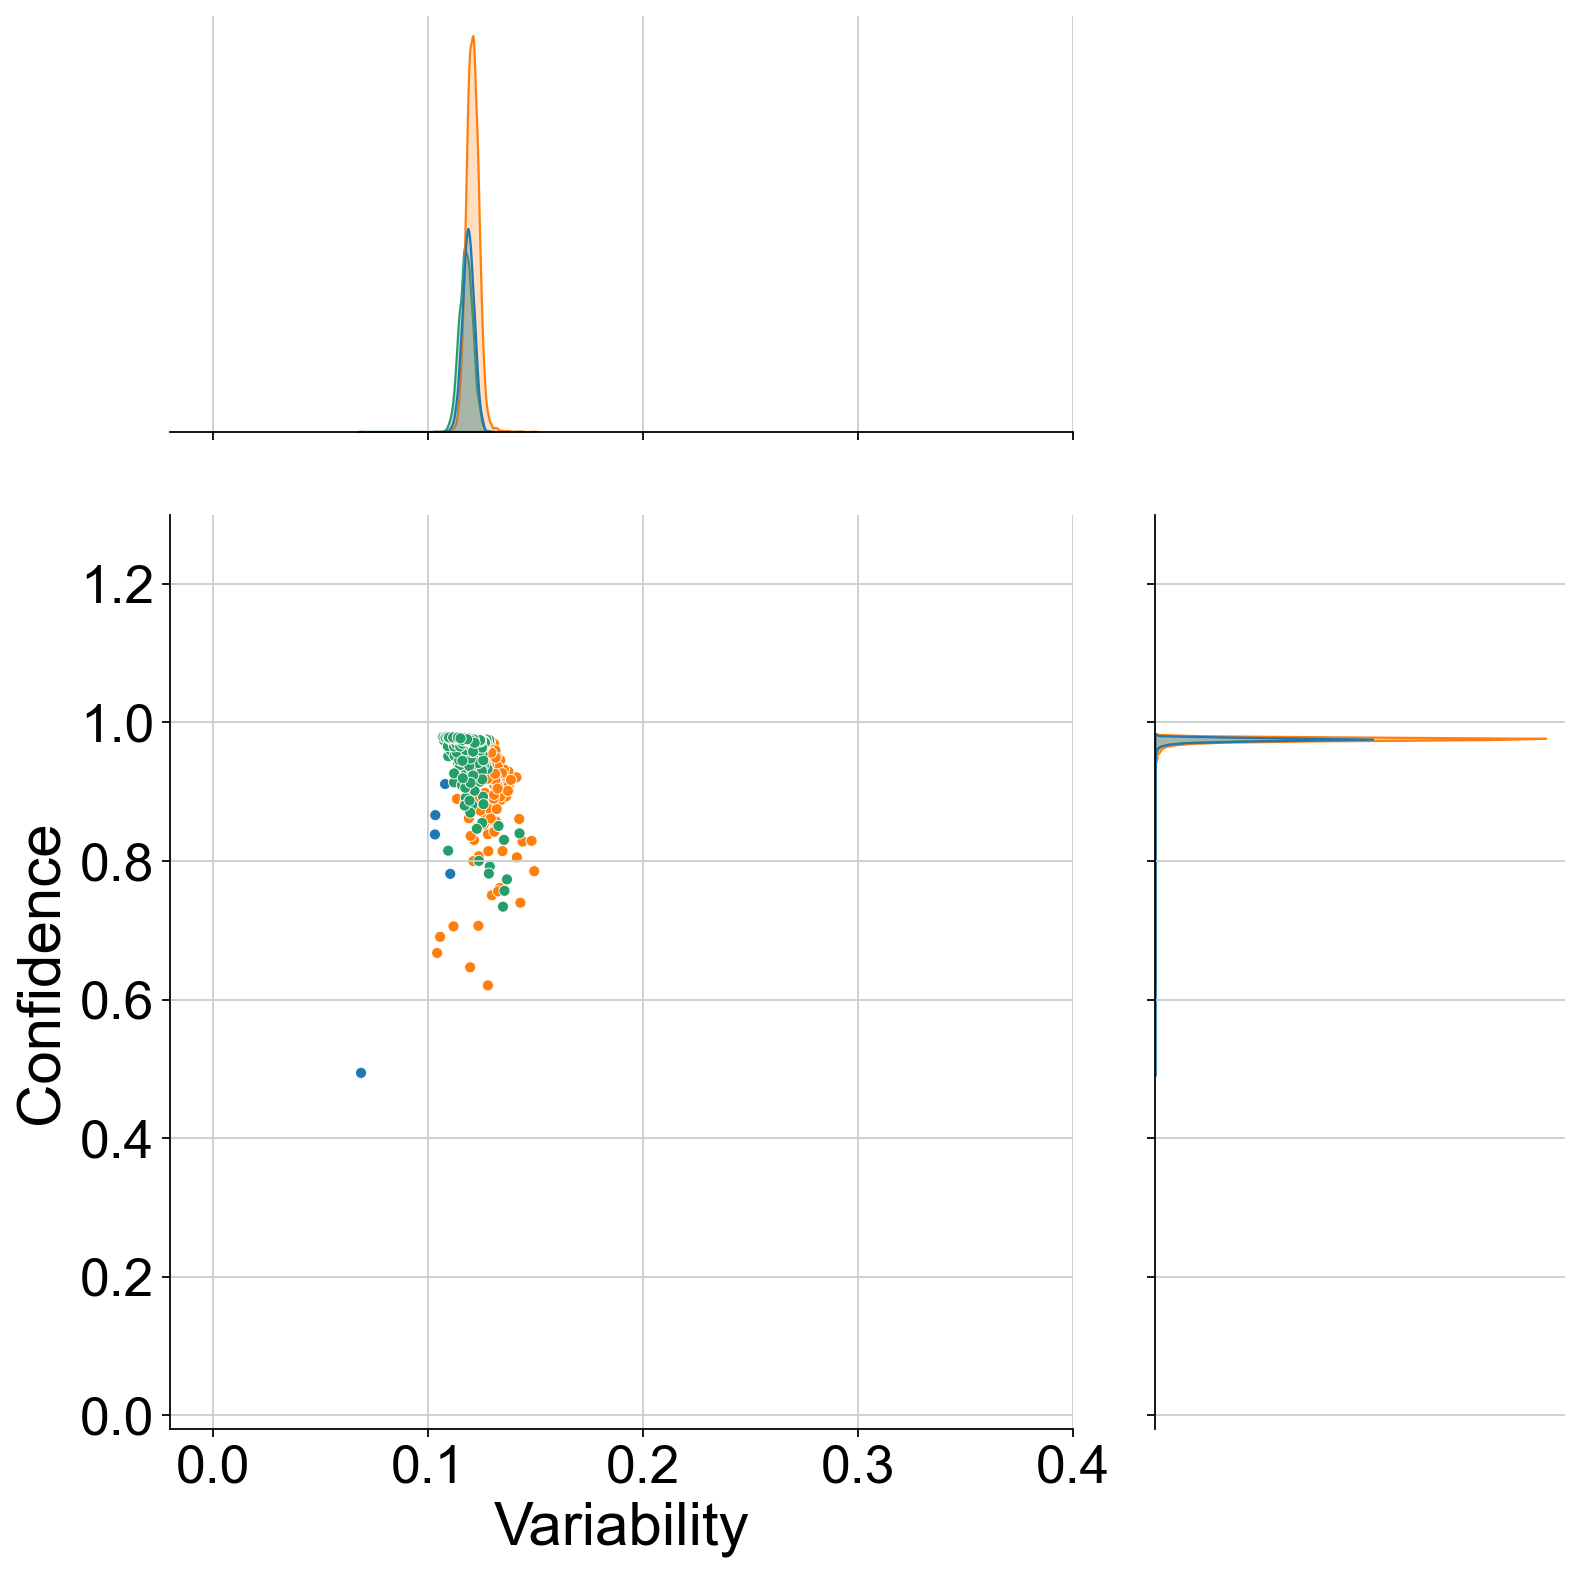

In [27]:
adata_celltype.obs['Confidence']= adata_celltype.obs['conf_celltype']
adata_celltype.obs['Variability']= adata_celltype.obs['var_celltype']
adata_celltype.obs['Cell type']= adata_celltype.obs['celltype']

fig = sns.jointplot(data=adata_celltype.obs, x="Variability", y="Confidence",hue='Cell type',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize
fig.ax_joint.legend_.remove()

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

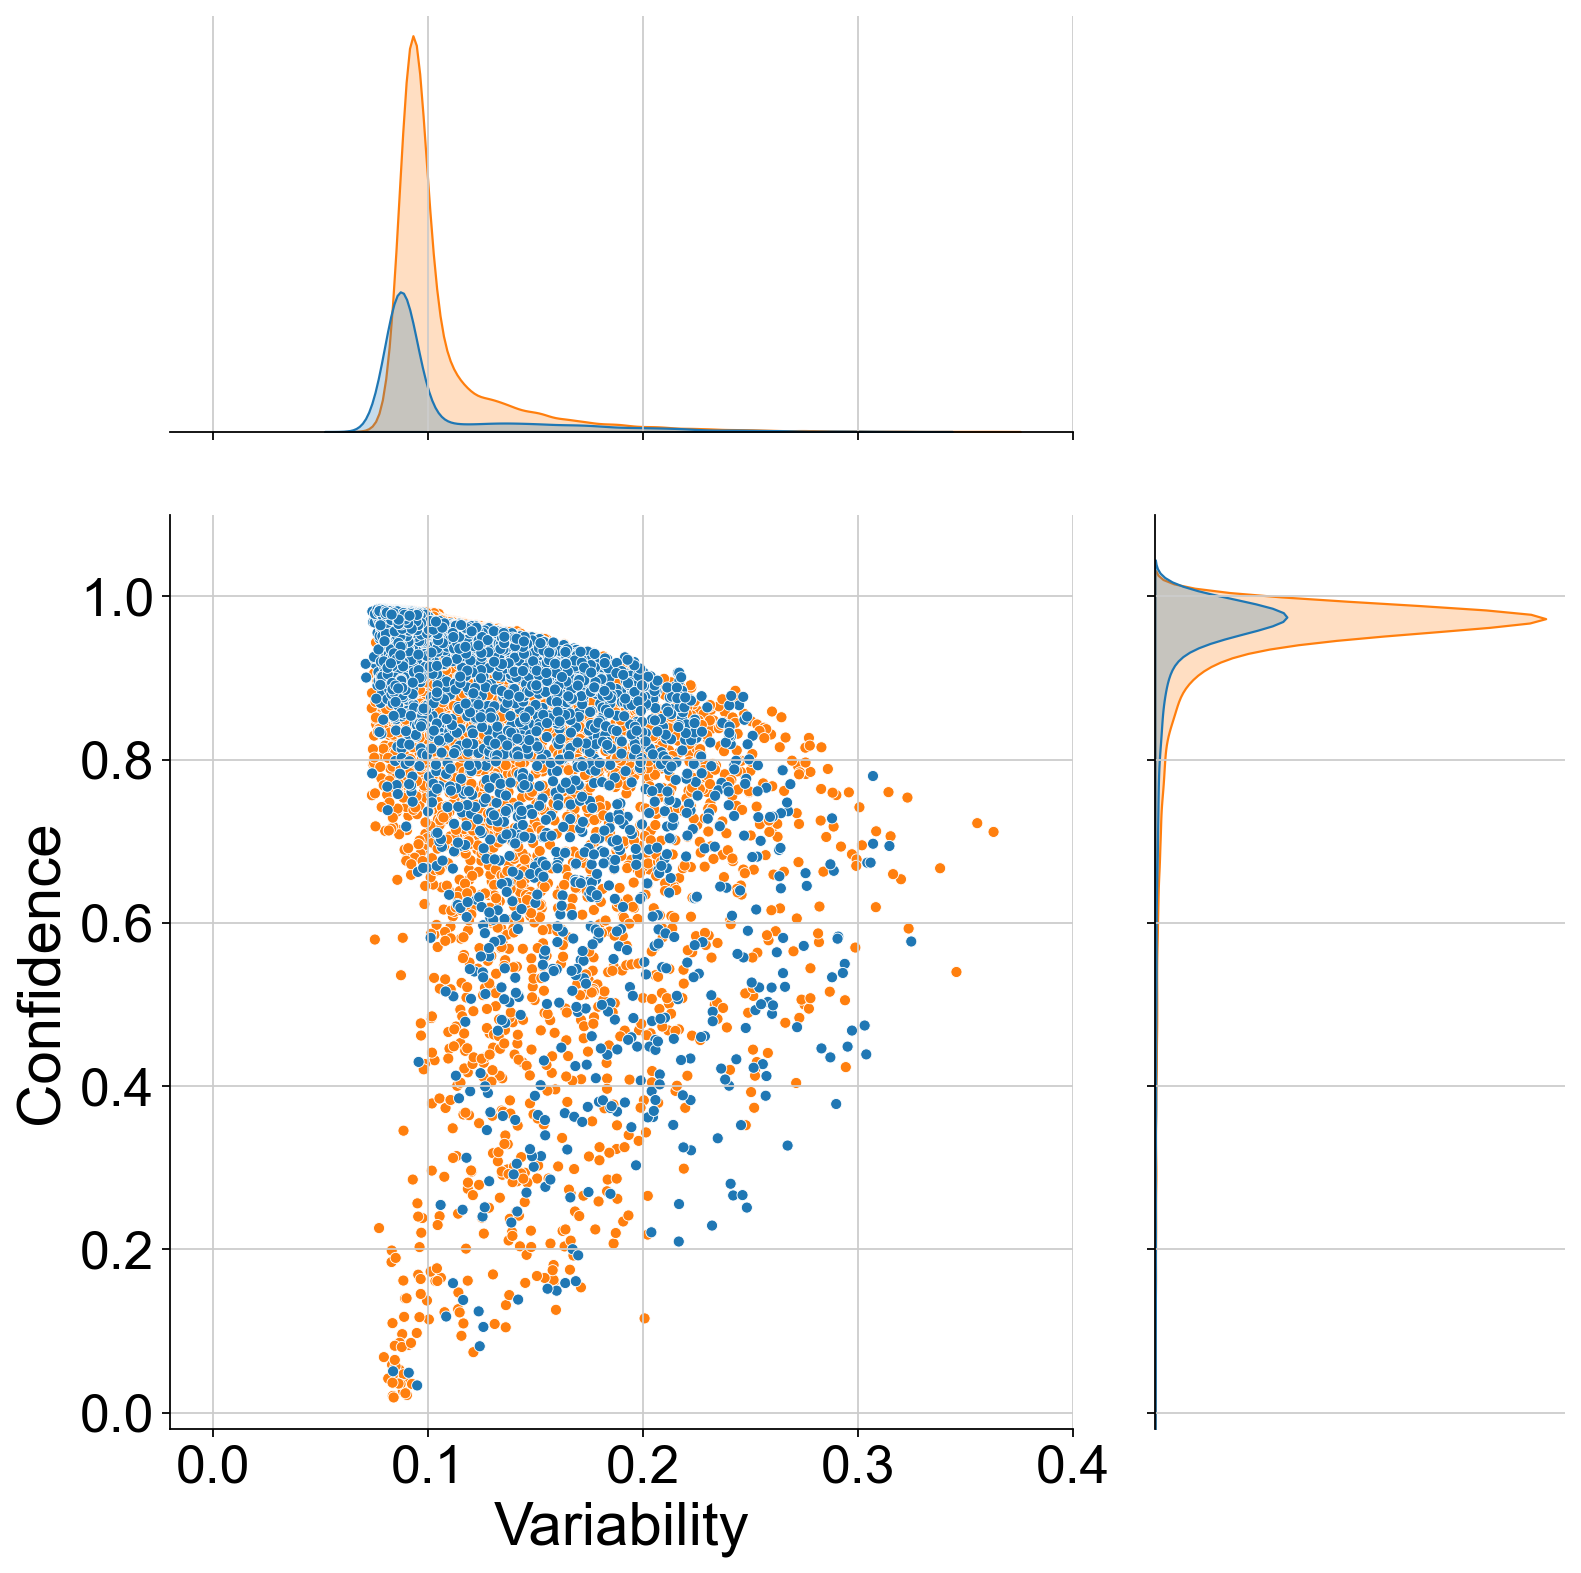

In [28]:
adata_stz_ctrl.obs['Confidence']= adata_stz_ctrl.obs['conf']
adata_stz_ctrl.obs['Variability']= adata_stz_ctrl.obs['var']

fig = sns.jointplot(data=adata_stz_ctrl.obs, x="Variability", y="Confidence",hue='cond',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.1])
fig.ax_joint.tick_params(axis='x', labelsize=24)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=24)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=27)  # Set the desired fontsize
fig.ax_joint.legend_.remove()

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=27)  # Set the desired fontsize
plt.show()

In [33]:
adata_stz_ctrl_name = 'extended_2_adata_ctz_ctrl.h5ad'
adata_stz_ctrl.write(adata_stz_ctrl_name)
adata_celltype_name = 'extended_2_adata_cell_type.h5ad'
adata_celltype.write(adata_celltype_name)
